In [1]:
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
import tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

2023-12-22 22:33:23.574895: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# load the .npz file of features
f = np.load(os.getcwd()+"/MusicFeatures.npz")
S = f['spec']
mfcc = f['mfcc']
mel = f['mel']
chroma = f['chroma']
y = f['target']

# split train-test data
S_train, S_test, mfcc_train, mfcc_test, mel_train, mel_test, chroma_train, chroma_test, y_train, y_test = train_test_split(S, mfcc, mel, chroma, y, test_size= 0.2)


: 

In [ ]:
# Spectrogram
maximum1 = np.amax(S_train)
S_train = S_train/np.amax(maximum1)
S_test = S_test/np.amax(maximum1)

S_train = S_train.astype(np.float32)
S_test = S_test.astype(np.float32)

N, row, col = S_train.shape
S_train = S_train.reshape((N, row, col, 1))

N, row, col = S_test.shape
S_test = S_test.reshape((N, row, col, 1))

In [ ]:
# MFCC
newtrain_mfcc = np.empty((mfcc_train.shape[0], 120, 600))
newtest_mfcc = np.empty((mfcc_test.shape[0], 120, 600))

for i in range(mfcc_train.shape[0]) :
    curr = mfcc_train[i]
    curr = cv2.resize(curr, (600, 120))
    newtrain_mfcc[i] = curr

mfcc_train = newtrain_mfcc

for i in range(mfcc_test.shape[0]) :

  curr = mfcc_test[i]
  curr = cv2.resize(curr, (600, 120))
  newtest_mfcc[i] = curr

mfcc_test = newtest_mfcc

mfcc_train = mfcc_train.astype(np.float32)
mfcc_test = mfcc_test.astype(np.float32)

N, row, col = mfcc_train.shape
mfcc_train = mfcc_train.reshape((N, row, col, 1))

N, row, col = mfcc_test.shape
mfcc_test = mfcc_test.reshape((N, row, col, 1))

mean_data = np.mean(mfcc_train)
std_data = np.std(mfcc_train)

mfcc_train = (mfcc_train - mean_data)/ std_data
mfcc_test = (mfcc_test - mean_data)/ std_data

In [ ]:
# Mel-Spectrogram

maximum = np.amax(mel_train)
mel_train = mel_train/np.amax(maximum)
mel_test = mel_test/np.amax(maximum)

mel_train = mel_train.astype(np.float32)
mel_test = mel_test.astype(np.float32)

N, row, col = mel_train.shape
mel_train = mel_train.reshape((N, row, col, 1))

N, row, col = mel_test.shape
mel_test = mel_test.reshape((N, row, col, 1))

In [ ]:
# Save Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_spectrogram_train_test.npz", S_train= S_train, S_test= S_test, y_train = y_train, y_test= y_test)

# Save MFCC train-test
np.savez_compressed(os.getcwd()+"/new_mfcc_train_test.npz", mfcc_train= mfcc_train, mfcc_test= mfcc_test, y_train = y_train, y_test= y_test)

# Save Mel-Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_mel_train_test.npz", mel_train= mel_train, mel_test= mel_test, y_train = y_train, y_test= y_test)


In [ ]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [ ]:
# Load Spectrogram Train-test data
spec_file = np.load(os.getcwd()+"/new_spectrogram_train_test.npz")

# Model 1 for Spectrogram
S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= S_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(8, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()

# Train Model 1

checkpoint = ModelCheckpoint(os.getcwd()+"/models/new_spec_model_spectrogram1_{epoch:03d}.h5", period= 5)

reset_keras()
model.fit(S_train, y_train, epochs= 200, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1025, 50, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 257, 13, 8)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 13, 16)       1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 4, 16)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 4, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 1, 32)        0

2023-12-22 19:09:32.163018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-22 19:09:34.982785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d1:00.0, compute capability: 8.6
2023-12-22 19:09:35.550624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d1:00.0, compute capability: 8.6


593


2023-12-22 19:09:35.571063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d1:00.0, compute capability: 8.6
2023-12-22 19:09:35.722405: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d1:00.0, compute capability: 8.6


Epoch 1/100


2023-12-22 19:09:39.932979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-22 19:09:42.748508: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


200/200 [==============================] - 7s 8ms/step - loss: 1.9729
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 1.8813
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 1.7636
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 1.6885
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 1.6348
Epoch 6/100
200/200 [==============================] - 2s 8ms/step - loss: 1.5797
Epoch 7/100
200/200 [==============================] - 2s 8ms/step - loss: 1.5443
Epoch 8/100
200/200 [==============================] - 2s 8ms/step - loss: 1.5022
Epoch 9/100
200/200 [==============================] - 2s 8ms/step - loss: 1.4716
Epoch 10/100
200/200 [==============================] - 2s 9ms/step - loss: 1.4393
Epoch 11/100
200/200 [==============================] - 2s 12ms/step - loss: 1.4283
Epoch 12/100
200/200 [==============================] - 2s 8ms/step - loss: 1.3915
Epoch 13/100
200/200 [==

200/200 [==============================] - 1s 5ms/step
Train Accuracy:  6228 / 6400  =  97.31 %
50/50 [==============================] - 0s 5ms/step
Test Accuracy:  660 / 1600  =  41.25 %
(8, 8)


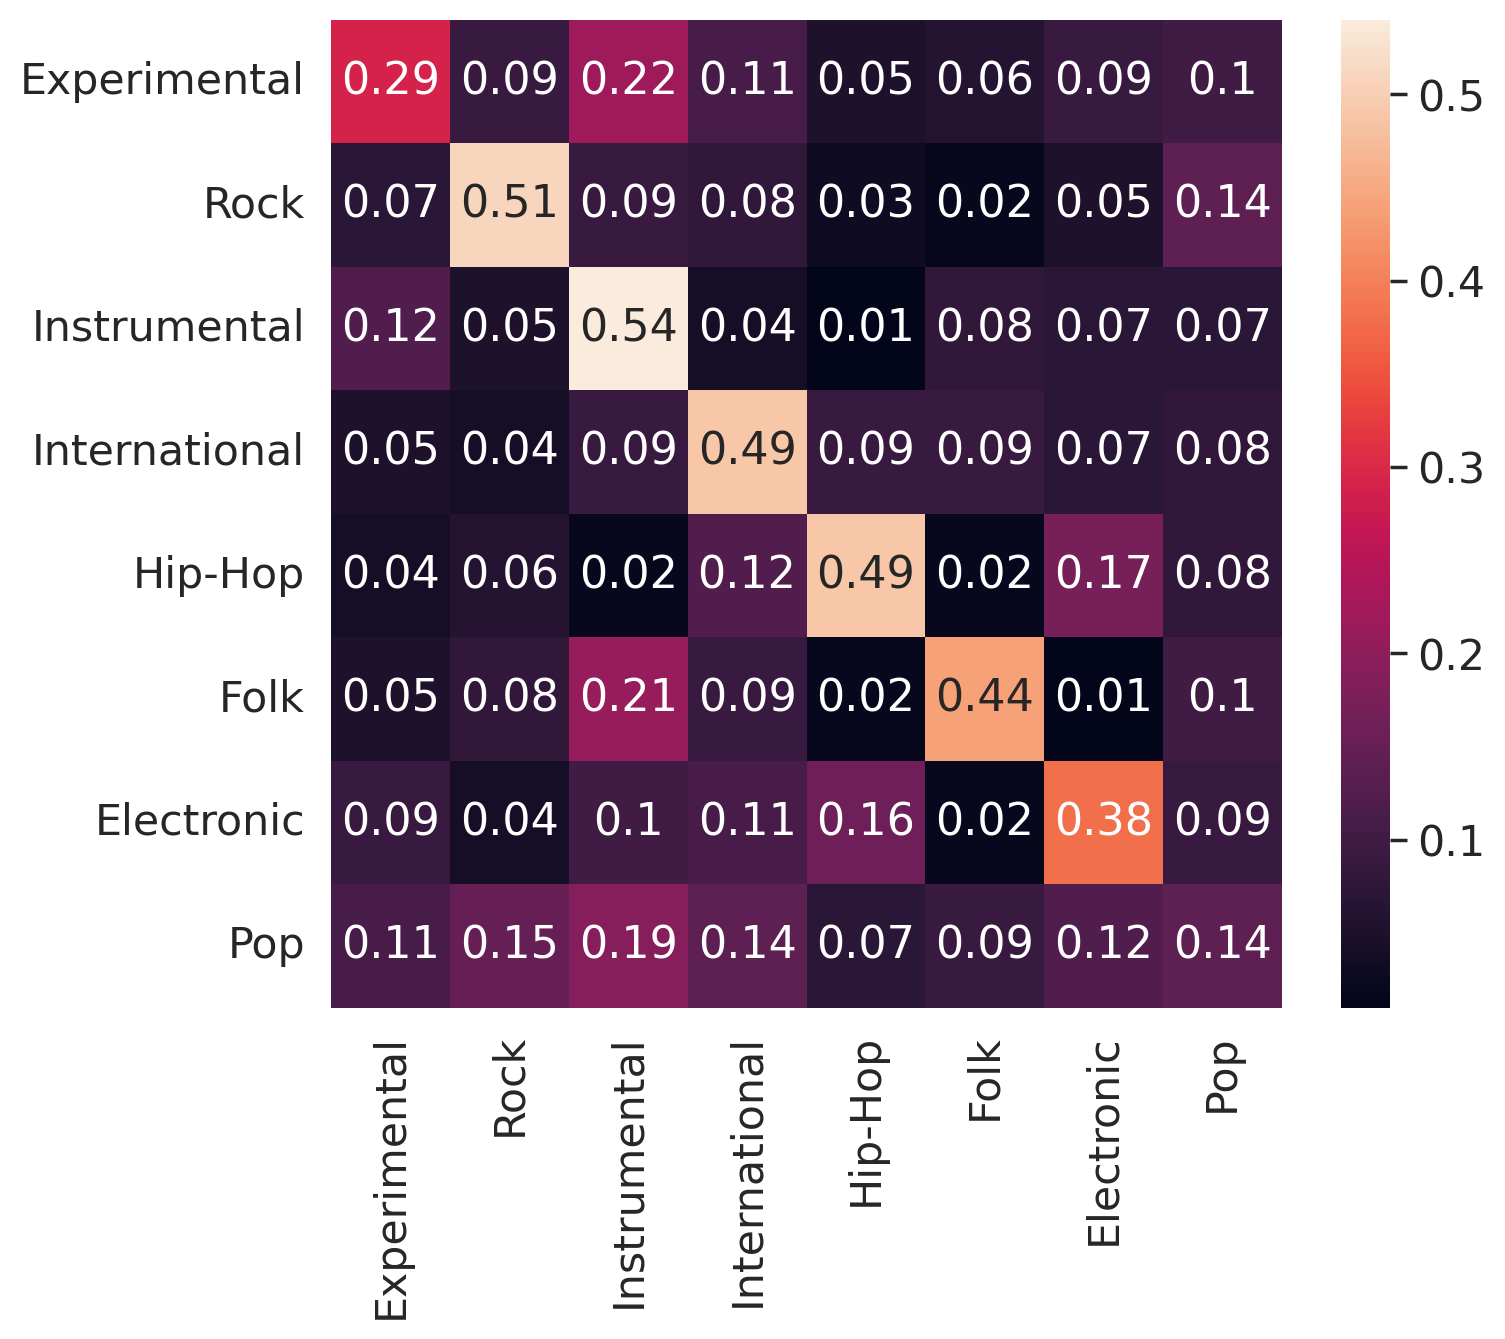

In [ ]:
model = load_model(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")

# Training Accuracy
y_pred = model.predict(S_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Testing Accuracy
y_pred = model.predict(S_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Test Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
print(conf_mat.shape)
conf_mat = np.round(conf_mat, 2)


conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (8,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")


In [ ]:
# Spectrogram Model 2

S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= S_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(8, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()

# Train Model 2

checkpoint = ModelCheckpoint(os.getcwd()+"/models/new_spec_model_spectrogram2_{epoch:03d}.h5", period= 5)

model.fit(S_train, y_train, epochs= 100, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/new_spec_model_spectrogram2.h5")

model = load_model(os.getcwd() + "/models/new_model_spectrogram2.h5")


# Training Accuracy
y_pred = model.predict(S_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Training Accuracy
y_pred = model.predict(S_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)
print(conf_mat.shape)
conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat2.png")

: 

In [ ]:
# Load MFCC file
mfcc_file = np.load(os.getcwd()+"/new_mfcc_train_test.npz")
mfcc_train = mfcc_file['mfcc_train']
mfcc_test = mfcc_file['mfcc_test']
y_train = mfcc_file['y_train']
y_test = mfcc_file['y_test']

# Define model for MFCC
def get_model() :

    model = Sequential()
    model.add(Conv2D(16, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Conv2D(32, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Conv2D(64, (3,3), input_shape= mfcc_train[0].shape, activation= 'tanh', padding= 'same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4,6), padding= 'same'))
    model.add(Flatten())
    # model.add(Dense(256, activation= 'tanh'))
    model.add(Dense(256, activation= 'tanh'))
    model.add(Dense(64, activation= 'tanh'))
    model.add(Dense(8, activation= 'softmax'))

    model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

    model.summary()

    return model

In [ ]:
# Function to get the majority vote
def get_majority(pred) :
  N = len(pred[0])
  vote = []
  for i in range(N) :
    candidates = [x[i] for x in pred]
    candidates = np.array(candidates)
    uniq, freq = np.unique(candidates, return_counts= True)
    vote.append(uniq[np.argmax(freq)])

    vote = np.array(vote)

    return vote

# Train Model 1

model1 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model1.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model1.save(os.getcwd() + "/models/new_ensemble_mfcc1.h5")

# Train Model 2

model2 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model2.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model2.save(os.getcwd() + "/models/new_ensemble_mfcc2.h5")

# Train Model 3

model3 = get_model()

kf = KFold(n_splits = 10)
for train_index, val_index in kf.split(mfcc_train, np.argmax(y_train, axis= -1)):

    kf_mfcc_train = mfcc_train[train_index]
    kf_X_val = mfcc_train[val_index]
    kf_y_train = y_train[train_index]
    kf_y_val = y_train[val_index]

    model3.fit(kf_mfcc_train, kf_y_train, validation_data= (kf_X_val, kf_y_val), epochs= 30, batch_size= 30, verbose= 1)
    model3.save(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

In [ ]:
# Load the models
model1 = load_model(os.getcwd() + "/models/new_ensemble_mfcc1.h5")
model2 = load_model(os.getcwd() + "/models/new_ensemble_mfcc2.h5")
model3 = load_model(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

# Training Accuracy
y_true = np.argmax(y_train, axis= -1)

y_pred1 = model1.predict(mfcc_train)
y_pred1 = np.argmax(y_pred1, axis= -1)

y_pred2 = model2.predict(mfcc_train)
y_pred2 = np.argmax(y_pred2, axis= -1)

y_pred3 = model3.predict(mfcc_train)
y_pred3 = np.argmax(y_pred3, axis= -1)

y_pred = [y_pred1, y_pred2, y_pred3]

y_pred = get_majority(y_pred)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Test Model
y_true = np.argmax(y_test, axis= -1)

y_pred1 = model1.predict(mfcc_test)
y_pred1 = np.argmax(y_pred1, axis= -1)

y_pred2 = model2.predict(mfcc_test)
y_pred2 = np.argmax(y_pred2, axis= -1)

y_pred3 = model3.predict(mfcc_test)
y_pred3 = np.argmax(y_pred3, axis= -1)

y_pred = [y_pred1, y_pred2, y_pred3]

y_pred = get_majority(y_pred)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_ensemble_mfcc_conf_mat.png")

In [ ]:
# Mel-Sprectrogram

# Load npz file of Mel-Spectrogram
file = np.load(os.getcwd()+"/new_mel_train_test.npz")
mel_train = file['mel_train']
mel_test = file['mel_test']
y_train = file['y_train']
y_test = file['y_test']

# Define the model
model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= mel_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()


# Train Model

checkpoint = ModelCheckpoint(os.getcwd()+"/models/ensemble_model_melspectrogram1_{epoch:03d}.h5", period= 5)

model.fit(mel_train, y_train, epochs= 200, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")

# Load the model
model = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")


# Training Accuracy
y_pred = model.predict(mel_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Testing Accuracy
y_pred = model.predict(mel_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100
print("Testing Accuracy", acc)

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (8,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/ensemble_mel_conf_mat1.png")

In [ ]:
# Load Spectrogram model 1
spec_file = np.load(os.getcwd()+"/new_spectrogram_train_test.npz")

S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model1 = load_model(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")

# Load Spectrogram model 2
S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model2 = load_model(os.getcwd() + "/models/new_spec_model_spectrogram2.h5")

# Load MFCC model 1,2 and 3
mfcc_file = np.load(os.getcwd()+"/new_mfcc_train_test.npz")
mfcc_train = mfcc_file['mfcc_train']
mfcc_test = mfcc_file['mfcc_test']
y_train = mfcc_file['y_train']
y_test = mfcc_file['y_test']

model3 = load_model(os.getcwd() + "/models/new_ensemble_mfcc1.h5")
model4 = load_model(os.getcwd() + "/models/new_ensemble_mfcc2.h5")
model5 = load_model(os.getcwd() + "/models/new_ensemble_mfcc3.h5")

# Load Mel-spectrogram model
file = np.load(os.getcwd()+"/new_mel_train_test.npz")
mel_train = file['mel_train']
mel_test = file['mel_test']
y_train = file['y_train']
y_test = file['y_test']

model6 = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")

In [ ]:
# Ground truth
y_true = np.argmax(y_train, axis= -1)

# Spectrogram model 1
y_pred1 = model1.predict(S_train)
y_pred1 = np.argmax(y_pred1, axis= -1)

# Spectrogram model 2
y_pred2 = model2.predict(S_train)
y_pred2 = np.argmax(y_pred2, axis= -1)

# MFCC model 1
y_pred3 = model3.predict(mfcc_train)
y_pred3 = np.argmax(y_pred3, axis= -1)

# MFCC model 2
y_pred4 = model4.predict(mfcc_train)
y_pred4 = np.argmax(y_pred4, axis= -1)

# MFCC model 3
y_pred5 = model5.predict(mfcc_train)
y_pred5 = np.argmax(y_pred5, axis= -1)

# Mel-spectrogram 
y_pred6 = model6.predict(mel_train)
y_pred6 = np.argmax(y_pred6, axis= -1)

# Get majority vote
y_pred = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
y_pred = get_majority(y_pred)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Training Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Test Model
y_true = np.argmax(y_test, axis= -1)
# Spectrogram model 1
y_pred1 = model1.predict(S_test)
y_pred1 = np.argmax(y_pred1, axis= -1)

# Spectrogram model 2
y_pred2 = model2.predict(S_test)
y_pred2 = np.argmax(y_pred2, axis= -1)

# MFCC model 1
y_pred3 = model3.predict(mfcc_test)
y_pred3 = np.argmax(y_pred3, axis= -1)

# MFCC model 2
y_pred4 = model4.predict(mfcc_test)
y_pred4 = np.argmax(y_pred4, axis= -1)

# MFCC model 3
y_pred5 = model5.predict(mfcc_test)
y_pred5 = np.argmax(y_pred5, axis= -1)

# Mel-Spectrogram 
y_pred6 = model6.predict(mel_test)
y_pred6 = np.argmax(y_pred6, axis= -1)

# Get majority vote
y_pred = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6]
y_pred = get_majority(y_pred)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100
print("Testing Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ['Experimental', 'Rock', 'Instrumental', 'International', 'Hip-Hop', 'Folk', 'Electronic', 'Pop']
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_ensemble_conf_mat.png")